# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [2]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from pathlib import Path
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [24]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
files = ["/global/cfs/cdirs/m3712/Mu2e/TARef_v7.root:TARmuM/trkana"]
    
#time = []
up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []
nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trkfit|trkmcsim/i",report=True):
    print("Fields available in 'trkfit':", ak.fields(batch["trkfit"]))
    # upstream and downstream tracks
    upstream = batch["trkfit"][:,0]
    downstream = batch["trkfit"][:,1]
    print("uspstream ",len(upstream)," downstream ",len(downstream))
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.sum(up_up,axis=1) > 0
    has_up_down = ak.sum(up_down,axis=1) > 0
    has_down_down = ak.sum(down_down,axis=1) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up = up_up[has_all]
    up_down = up_down[has_all]
    down_down = down_down[has_all]
 #   print("has_all ",len(has_up_up),len(has_up_down),len(has_down_down),len(has_all))
#    #print("has_all ",ak.num(has_up_up,axis=1),ak.num(has_up_down,axis=1),ak.num(has_down_down,axis=1),ak.num(has_all,axis=1))
#    print("nums axis=0", ak.num(up_up, axis=0), ak.num(up_down, axis=0), ak.num(down_down, axis=0))
#    print("nums axis=1", ak.num(up_up, axis=1), ak.num(up_down, axis=1), ak.num(down_down, axis=1))
#    print("masked", ak.num(upstream[has_all], axis=0), ak.num(upstream[has_all], axis=1))
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))                      
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    uptrkmcsim = uptrkmcsim[has_all]
    downtrkmcsim = downtrkmcsim[has_all]
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))
    
    nipaup = batch["trk.nipaup"][:,0] # only need upstream track for material intersection counting
    nipadown = batch["trk.nipadown"][:,0]
    nstup = batch["trk.nstup"][:,0]
    nstdown = batch["trk.nstdown"][:,0]
    nipaup = nipaup[has_all]
    nipadown = nipadown[has_all]
    nstup = nstup[has_all]
    nstdown = nstdown[has_all]
    
    nipa_up.extend(nipaup)
    nipa_down.extend(nipadown)
    nst_up.extend(nstup)    
    nst_down.extend(nstdown)
    

deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

#print("NIPA_up",len(nipa_up),nipa_up[:10])

up_px = np.square(up_px)
up_py = np.square(up_py)
up_pz = np.square(up_pz)
down_px = np.square(down_px)
down_py = np.square(down_py)
down_pz = np.square(down_pz)
up_mom = np.sqrt(np.add(up_px,up_py,up_pz))
down_mom = np.sqrt(np.add(down_px,down_py,down_pz))

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",len(up_mom),up_mom[:10])
print("Downstream momentum ",len(down_mom),down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())
print("nmat ",len(nmat))
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])

Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3109  downstream  3109
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3109  downstream  3109
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3109  downstream  3109
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  2183  downstream  2183
Upstream momentum  11509 [ 81.41487   88.966255 101.19896   87.768585  75.5024    99.83975
 182.89815   70.08049  110.88534   55.68704 ]
Downstream momentum  11509 [ 82.00639   91.927055  92.913666  86.01195   77.21989   99.0571
 181.80164   71.08228  110.75502   53.062332]
Upstream fit upstream time  11509 [913.3951248667264, 600.2851505079944, 992.9050206508748, 1

Label true elec

In [25]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])


True Electrons 11509 [False False False False False False False False False False]
True Muons 11509 [ True  True  True  True  True  True  True  True  True  True]


11509 11509
N true electrons  331  N true muons  11175


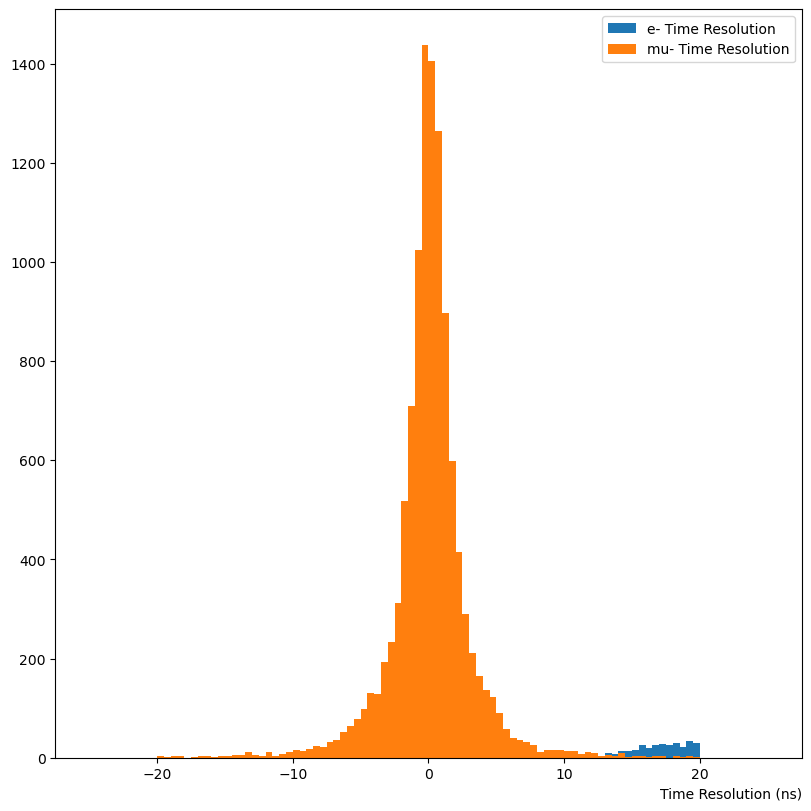

In [26]:
print(len(up_down_time),len(down_down_time))
time_diff = np.subtract(up_down_time,down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(8, 8))
ax.hist(em_time_diff,label="e- Time Resolution", bins=100,range=(-25,25))
ax.hist(mum_time_diff,label="mu- Time Resolution", bins=100,range=(-25,25))
ax.set_xlabel("Time Resolution (ns)",loc='right')
ax.legend()

In [27]:
abs_time_diff = np.absolute(time_diff)
good_mum = []
max_tdiff = 8.0
for tdiff in abs_time_diff :
    good_mum.append( tdiff <  max_tdiff)
print("Good muon ",len(good_mum),good_mum[:10])
good_mum = np.array(good_mum)
true_good_mum = good_mum[true_mum]
eff = good_mum.sum()/true_mum.sum()
pur = true_good_mum.sum()/good_mum.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good muon  11509 [True, True, True, True, True, True, True, True, True, True]
For Delta T <  8.0  efficiency =  0.9715436241610739  purity =  0.999539467624574


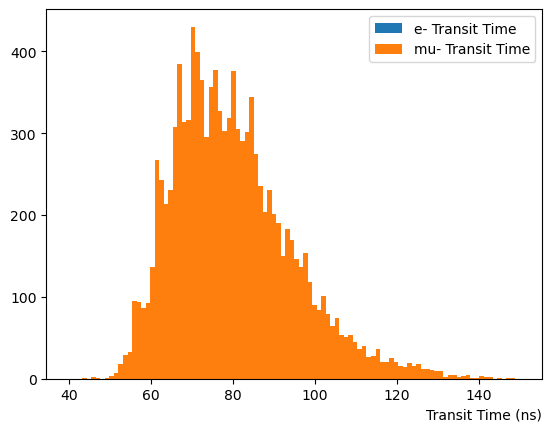

In [34]:
transit_time = np.subtract(up_down_time,up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,150))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,150))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

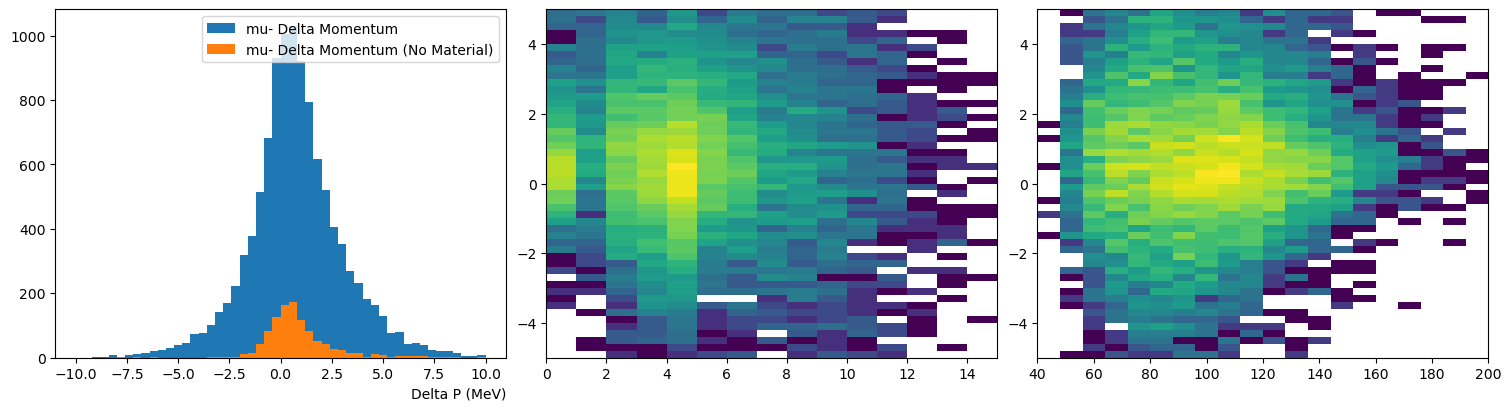

In [37]:
mom_diff = np.subtract(up_mom,down_mom)
nomat = []
for nm in nmat :
    nomat.append( nm <1 )
nomat = np.array(nomat)
good_mum_nomat = np.logical_and(nomat,true_mum)

em_mom_diff = mom_diff[good_mum]
em_mom_diff_nomat = mom_diff[good_mum_nomat]
nmat_good = nmat[good_mum]
up_mom_good = up_mom[good_mum]

fig, (ax0, ax1, ax2)  = plt.subplots(1,3,layout='constrained', figsize=(15,4))
dmom = ax0.hist(em_mom_diff,label="mu- Delta Momentum", bins=50,range=(-10,10))
dmom_nomat = ax0.hist(em_mom_diff_nomat,label="mu- Delta Momentum (No Material)", bins=50,range=(-10,10))
ax0.set_xlabel("Delta P (MeV)",loc='right')
ax0.legend()
dmom_v_nmat = ax1.hist2d(nmat_good,em_mom_diff,bins=(15,50),range=([0,15],[-5,5]),norm=mpl.colors.LogNorm())
dmom_v_mom = ax2.hist2d(up_mom_good,em_mom_diff,bins=(20,50),range=([40,200],[-5,5]),norm=mpl.colors.LogNorm())

In [46]:
plt.show()